In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import callbacks, models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
# bag of words

In [2]:
BASE = '/kaggle/input/word2vec-nlp-tutorial'
MAX_WORDS = 25_000

In [3]:
train = pd.read_csv("data/labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test = pd.read_csv("data/testData.tsv", header=0, delimiter="\t", quoting=3)

In [4]:
#train = pd.read_csv(os.path.join(BASE,'labeledTrainData.tsv.zip'), header=0, delimiter="\t", quoting=3)
train.shape

(25000, 3)

In [5]:
#test = pd.read_csv(os.path.join(BASE,'testData.tsv.zip'), header=0, delimiter="\t", quoting=3)
test.shape

(25000, 2)

In [6]:
print(train["sentiment"][0])
train["review"][0]

1


'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [7]:
stop_words = stopwords.words("english")
def clean(review):
    clean_html = BeautifulSoup(review).get_text()
    clean_non_letters = re.sub("[^a-zA-Z]", " ", clean_html)
    cleaned_lowercase = clean_non_letters.lower()
    words = cleaned_lowercase.split()
    cleaned_words = [w for w in words if w not in stop_words]
    return " ".join(cleaned_words)

train["cleaned_review"] = train["review"].apply(clean)
train

E:\anaconda_neve\envs\amls2\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


,id,sentiment,review,cleaned_review
0,"""5814_8""",1,"""With all this stuff going down at the moment ...",stuff going moment mj started listening music ...
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ...",classic war worlds timothy hines entertaining ...
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell...",film starts manager nicholas bell giving welco...
3,"""3630_4""",0,"""It must be assumed that those who praised thi...",must assumed praised film greatest filmed oper...
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ...",superbly trashy wondrously unpretentious explo...
...,...,...,...,...
24995,"""3453_3""",0,"""It seems like more consideration has gone int...",seems like consideration gone imdb reviews fil...
24996,"""5064_1""",0,"""I don't believe they made this film. Complete...",believe made film completely unnecessary first...
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui...",guy loser get girls needs build picked stronge...
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the...",minute documentary bu uel made early one spain...


In [8]:
# with no constraints there are 74_066 words in the training set
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train.cleaned_review)
total_words = len(tokenizer.word_index) + 1
total_words

74066

In [9]:
sequences = tokenizer.texts_to_sequences(train.cleaned_review)
max_sequence_len = max([len(x) for x in sequences])
padded_sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))
labels = np.array(train.sentiment)
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(20000, 1322) (20000,) (5000, 1322) (5000,)


In [10]:
def to_dataset(data, labels):
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    dataset = dataset.cache().shuffle(X_train.shape[0] + 1).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
train_ds = to_dataset(X_train, y_train)
val_ds = to_dataset(X_val, y_val)

In [11]:
LSTM_SIZE = 8
def bi_lstm_model():
    model = models.Sequential()
    model.add(layers.Embedding(total_words, 16, input_length=max_sequence_len - 1))
    model.add(layers.Bidirectional(layers.LSTM(LSTM_SIZE)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model, f'bidirectional_lstm_{LSTM_SIZE}'

def lstm_model():
    model = models.Sequential()
    model.add(layers.Embedding(total_words, 4, input_length=max_sequence_len - 1))
    model.add(layers.LSTM(LSTM_SIZE))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model, f'lstm_{LSTM_SIZE}'

In [12]:
def tokenizer_train(model, name):
    reducer = callbacks.ReduceLROnPlateau(monior='val_loss', factor=0.5, patience=3, mode='min', cooldown=1)
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=6, mode='min', restore_best_weights=True)#本身为True
    hist = model.fit(train_ds,
              epochs=100,
              verbose=1,
              callbacks=[reducer,stopper],
              validation_data=val_ds)
    results = model.evaluate(val_ds)
    model.save(f'/kaggle/working/{name}')
    print(f"results: {results}, type: {type(results)}")
    return hist

In [13]:
model, name = lstm_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1321, 4)           296264    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 296,689
Trainable params: 296,689
Non-trainable params: 0
_________________________________________________________________


In [14]:
hist = tokenizer_train(model, name)

Epoch 1/100
625/625 [==============================] - 29s 42ms/step - loss: 0.5193 - binary_accuracy: 0.7643 - val_loss: 0.3483 - val_binary_accuracy: 0.8646
Epoch 2/100
625/625 [==============================] - 26s 42ms/step - loss: 0.2462 - binary_accuracy: 0.9115 - val_loss: 0.2747 - val_binary_accuracy: 0.8930
Epoch 3/100
625/625 [==============================] - 26s 42ms/step - loss: 0.1403 - binary_accuracy: 0.9568 - val_loss: 0.3192 - val_binary_accuracy: 0.8870
Epoch 4/100
625/625 [==============================] - 26s 42ms/step - loss: 0.0873 - binary_accuracy: 0.9761 - val_loss: 0.3471 - val_binary_accuracy: 0.8836
Epoch 5/100
625/625 [==============================] - 26s 42ms/step - loss: 0.0595 - binary_accuracy: 0.9841 - val_loss: 0.3956 - val_binary_accuracy: 0.8786
Epoch 6/100
625/625 [==============================] - 26s 42ms/step - loss: 0.0349 - binary_accuracy: 0.9926 - val_loss: 0.4360 - val_binary_accuracy: 0.8794
Epoch 7/100
625/625 [=========================

INFO:tensorflow:Assets written to: /kaggle/working/lstm_8\assets


INFO:tensorflow:Assets written to: /kaggle/working/lstm_8\assets


results: [0.27467456459999084, 0.8930000066757202], type: <class 'list'>


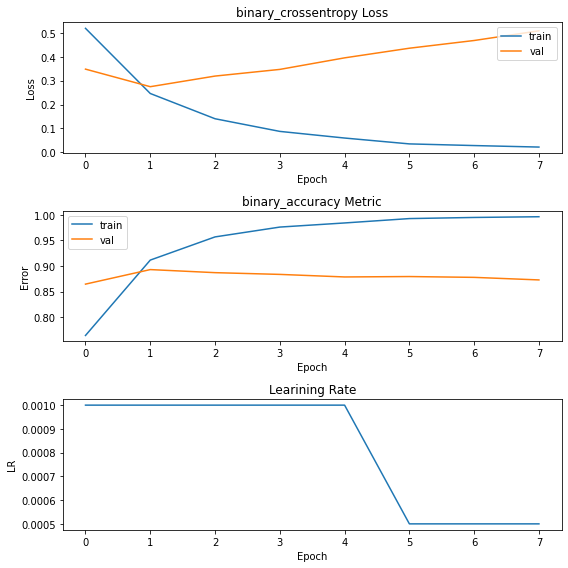

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(8,8), tight_layout=True)
    
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_title('binary_crossentropy Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='upper right')

axs[1].plot(hist.history['binary_accuracy'])
axs[1].plot(hist.history['val_binary_accuracy'])
axs[1].set_title('binary_accuracy Metric')
axs[1].set_ylabel('Error')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='upper left')

axs[2].plot(hist.history['lr'])
axs[2].set_title('Learining Rate')
axs[2].set_ylabel('LR')
axs[2].set_xlabel('Epoch')
plt.savefig(f'/kaggle/working/{name}_graphs.png')
plt.show()

In [16]:
test["cleaned_review"] = test["review"].apply(clean)
test

E:\anaconda_neve\envs\amls2\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


,id,review,cleaned_review
0,"""12311_10""","""Naturally in a film who's main themes are of ...",naturally film main themes mortality nostalgia...
1,"""8348_2""","""This movie is a disaster within a disaster fi...",movie disaster within disaster film full great...
2,"""5828_4""","""All in all, this is a movie for kids. We saw ...",movie kids saw tonight child loved one point k...
3,"""7186_2""","""Afraid of the Dark left me with the impressio...",afraid dark left impression several different ...
4,"""12128_7""","""A very accurate depiction of small time mob l...",accurate depiction small time mob life filmed ...
...,...,...,...
24995,"""2155_10""","""Sony Pictures Classics, I'm looking at you! S...",sony pictures classics looking sony got rights...
24996,"""59_10""","""I always felt that Ms. Merkerson had never go...",always felt ms merkerson never gotten role fit...
24997,"""2531_1""","""I was so disappointed in this movie. I am ver...",disappointed movie familiar case read mark fuh...
24998,"""7772_8""","""From the opening sequence, filled with black ...",opening sequence filled black white shots remi...


In [17]:
sequences = tokenizer.texts_to_sequences(test.cleaned_review)
test_sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))
print(test_sequences.shape)

(25000, 1322)


In [18]:
predictions = model.predict(test_sequences).flatten()

In [19]:
predictions.shape

(25000,)

In [22]:
predictions

array([0.9720953 , 0.02675665, 0.29099417, ..., 0.03991925, 0.97434163,
       0.08927106], dtype=float32)

In [20]:
output = pd.DataFrame(data={"id":test.id, "sentiment":predictions})
output.to_csv("word_tokenization_model.csv", index=False, quoting=3)

In [21]:
#准确率的函数
def classified_correct(model, i):
    return (model["sentiment"][i] == 0 and int(model["id"][i].split("_")[1]) <= 5) or \
           (model["sentiment"][i] == 1 and int(model["id"][i].split("_")[1]) > 5)

model = pd.read_csv("word_tokenization_model.csv");
correct = np.array([classified_correct(model,i) for i in range(model.shape[0])])
print(correct.sum() / model.shape[0]) # the accuracy

0.0
